# Business Scenario

**You work in a data science team under one of the biggest Telecommunications company in the United States, TrustTelecom**. As the industry is highly competitive, and customers have the freedom to choose from a variety of service providers and actively switch from one to the next, making it incredibly challenging for companies to retain their customers. In fact, acquiring new customers is not only more difficult but also much more costly than maintaining existing customer relationships.

**You have been tasked by higher management to build a customer churn prediction model** to identify customers who are likely to “churn”, i.e. switch to another service provider in the next month. This helps the customer care team reach out in a timely manner to understand user frustrations (if any), and extend the necessary discounts, offers and refunds in a bid to retain these customers in the long run.

For this capstone project, you will work with a colleague to build a machine learning classifier that predicts if a particular customer is likely to churn. After selecting a model that optimizes for the **********************************Area Under Curve (AUC)********************************** metric, you shall next embark on the task of deploying this model for your company’s Customer Care team.

This notebook is broken down with the following approach:
1. Connecting to SQL
2. EDA - Visualization.
3. Feature Engineering
4. Experimentation Modelling
5. Hyperparameter Tuning.
6. Exporting Pickle file.

## 1. Connecting to SQL

In [1]:

import pandas as pd
import os
from sqlalchemy import create_engine, text, inspect
from dotenv import  load_dotenv, dotenv_values

load_dotenv()



True

In [2]:
ENDPOINT = os.getenv('DB_HOST')
PORT = os.getenv('DB_PORT')
USERNAME = os.getenv('DB_USER')
PASSWORD = os.getenv('DB_PASSWORD')
DBNAME = os.getenv('DB_NAME')

In [3]:
database_conn = create_engine(f'mysql+pymysql://{USERNAME}:{PASSWORD}@{ENDPOINT}/{DBNAME}')

In [4]:
query = """
    SELECT * FROM account
    LIMIT 1;
"""

df = pd.read_sql(query, database_conn)
df

,account_id,customer_id,tenure_months,num_referrals,has_internet_service,internet_type,has_unlimited_data,has_phone_service,has_multiple_lines,has_premium_tech_support,has_online_security,has_online_backup,has_device_protection,contract_type,paperless_billing,payment_method
0,AAJU-HMJLK,0334-ZFJSR,55,0,Yes,Cable,No,Yes,Yes,Yes,Yes,Yes,No,One Year,Yes,Credit Card


In [5]:
query = """
SELECT *
FROM churn_status AS cs
JOIN customer AS c ON cs.customer_id = c.customer_id
JOIN account AS a ON cs.customer_id = a.customer_id
JOIN account_usage AS au ON a.account_id = au.account_id
JOIN city AS city ON c.zip_code = city.zip_code
Limit 5

"""

df = pd.read_sql(query, database_conn)
df

,customer_id,status,churn_label,churn_category,churn_reason,customer_id,gender,age,senior_citizen,married,...,stream_music,total_monthly_fee,total_charges_quarter,total_refunds,area_id,zip_code,city,latitutde,longitude,population
0,0013-EXCHZ,Churned,Yes,Dissatisfaction,Network reliability,0013-EXCHZ,Female,75,Yes,Yes,...,No,83.90,267.40,0.0,607,93010,Camarillo,34.227846,-119.079903,42853
1,0014-BMAQU,Stayed,No,,,0014-BMAQU,Male,52,No,Yes,...,No,84.65,5377.80,0.0,963,94558,Napa,38.489789,-122.270110,63947
2,0016-QLJIS,Stayed,No,,,0016-QLJIS,Female,43,No,Yes,...,Yes,90.45,5957.90,0.0,1390,95681,Sheridan,38.984756,-121.345074,1219
3,0019-EFAEP,Stayed,No,,,0019-EFAEP,Female,32,No,No,...,No,101.30,7261.25,0.0,303,91942,La Mesa,32.782501,-117.016110,24005
4,0019-GFNTW,Stayed,No,,,0019-GFNTW,Female,39,No,No,...,No,45.05,2560.10,0.0,716,93441,Los Olivos,34.704340,-120.026090,1317


In [6]:
query = """
SELECT 
cs.customer_id, cs.status, cs.churn_label, cs.churn_category, cs.churn_reason, 
c.gender, c.age, c.senior_citizen, c.married, c.num_dependents, c.zip_code, 
a.account_id, a.tenure_months, a.num_referrals, a.has_internet_service, a.internet_type, a.has_unlimited_data, a.has_phone_service, a.has_multiple_lines, a.has_premium_tech_support,
a.has_online_security,a.has_online_backup, a.has_device_protection, a.contract_type, a.paperless_billing, a.payment_method,
au.avg_long_distance_fee_monthly, au.total_long_distance_fee, au.avg_gb_download_monthly, au.stream_tv, au.stream_movie, au.stream_music, au.total_monthly_fee, au.total_charges_quarter, au.total_refunds,
city.area_id, city.population, city.city

FROM churn_status AS cs
JOIN customer AS c ON cs.customer_id = c.customer_id
JOIN account AS a ON cs.customer_id = a.customer_id
JOIN account_usage AS au ON a.account_id = au.account_id
JOIN city AS city ON c.zip_code = city.zip_code

"""

df = pd.read_sql(query, database_conn)
df

,customer_id,status,churn_label,churn_category,churn_reason,gender,age,senior_citizen,married,num_dependents,...,avg_gb_download_monthly,stream_tv,stream_movie,stream_music,total_monthly_fee,total_charges_quarter,total_refunds,area_id,population,city
0,0013-EXCHZ,Churned,Yes,Dissatisfaction,Network reliability,Female,75,Yes,Yes,0,...,11,Yes,No,No,83.90,267.40,0.00,607,42853,Camarillo
1,0014-BMAQU,Stayed,No,,,Male,52,No,Yes,0,...,7,No,No,No,84.65,5377.80,0.00,963,63947,Napa
2,0016-QLJIS,Stayed,No,,,Female,43,No,Yes,1,...,14,Yes,Yes,Yes,90.45,5957.90,0.00,1390,1219,Sheridan
3,0019-EFAEP,Stayed,No,,,Female,32,No,No,0,...,16,Yes,No,No,101.30,7261.25,0.00,303,24005,La Mesa
4,0019-GFNTW,Stayed,No,,,Female,39,No,No,0,...,19,No,No,No,45.05,2560.10,0.00,716,1317,Los Olivos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9412-ARGBX,Churned,Yes,Competitor,Competitor made better offer,Female,47,No,No,0,...,29,Yes,No,No,95.50,4627.85,0.00,72,40152,Downey
7039,9522-ZSINC,Stayed,No,,,Male,34,No,No,0,...,0,No,No,No,19.95,253.80,0.00,1226,25718,Santa Rosa
7040,9524-EGPJC,Churned,Yes,Competitor,Competitor offered higher download speeds,Female,33,No,No,0,...,19,No,Yes,Yes,90.10,1612.75,48.26,991,18024,Walnut Creek
7041,9975-SKRNR,Joined,No,,,Male,24,No,No,0,...,0,No,No,No,18.90,18.90,0.00,1611,227,Sierraville


In [7]:
df.columns

Index(['customer_id', 'status', 'churn_label', 'churn_category',
       'churn_reason', 'gender', 'age', 'senior_citizen', 'married',
       'num_dependents', 'zip_code', 'account_id', 'tenure_months',
       'num_referrals', 'has_internet_service', 'internet_type',
       'has_unlimited_data', 'has_phone_service', 'has_multiple_lines',
       'has_premium_tech_support', 'has_online_security', 'has_online_backup',
       'has_device_protection', 'contract_type', 'paperless_billing',
       'payment_method', 'avg_long_distance_fee_monthly',
       'total_long_distance_fee', 'avg_gb_download_monthly', 'stream_tv',
       'stream_movie', 'stream_music', 'total_monthly_fee',
       'total_charges_quarter', 'total_refunds', 'area_id', 'population',
       'city'],
      dtype='object')

In [8]:
df.shape

(7043, 38)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    7043 non-null   object 
 1   status                         7043 non-null   object 
 2   churn_label                    7043 non-null   object 
 3   churn_category                 7043 non-null   object 
 4   churn_reason                   7043 non-null   object 
 5   gender                         7043 non-null   object 
 6   age                            7043 non-null   int64  
 7   senior_citizen                 7043 non-null   object 
 8   married                        7043 non-null   object 
 9   num_dependents                 7043 non-null   int64  
 10  zip_code                       7043 non-null   int64  
 11  account_id                     7043 non-null   object 
 12  tenure_months                  7043 non-null   i

In [10]:
# Get overall statistics of dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,7043.0,46.509726,16.750352,19.00,32.000,46.00,60.000,80.00
num_dependents,7043.0,0.468692,0.962802,0.00,0.000,0.00,0.000,9.00
zip_code,7043.0,93486.070567,1856.767505,90001.00,92101.000,93518.00,95329.000,96150.00
tenure_months,7043.0,32.386767,24.542061,1.00,9.000,29.00,55.000,72.00
num_referrals,7043.0,1.951867,3.001199,0.00,0.000,0.00,3.000,11.00
avg_long_distance_fee_monthly,7043.0,22.958954,15.448113,0.00,9.210,22.89,36.395,49.99
total_long_distance_fee,7043.0,749.099262,846.660055,0.00,70.545,401.44,1191.100,3564.72
avg_gb_download_monthly,7043.0,20.515405,20.418940,0.00,3.000,17.00,27.000,85.00
total_monthly_fee,7043.0,64.761692,30.090047,18.25,35.500,70.35,89.850,118.75
total_charges_quarter,7043.0,2280.381264,2266.220462,18.80,400.150,1394.55,3786.600,8684.80


In [11]:
# Export DataFrame to CSV
directory = "../data/"
filename = "filename.csv"
full_path = directory + filename

df.to_csv(full_path, index=False)


Reread the data back into dataframe

In [12]:
df = pd.read_csv(full_path)

# Display the first few rows of the loaded data
df.head()


,customer_id,status,churn_label,churn_category,churn_reason,gender,age,senior_citizen,married,num_dependents,...,avg_gb_download_monthly,stream_tv,stream_movie,stream_music,total_monthly_fee,total_charges_quarter,total_refunds,area_id,population,city
0,0013-EXCHZ,Churned,Yes,Dissatisfaction,Network reliability,Female,75,Yes,Yes,0,...,11,Yes,No,No,83.90,267.40,0.0,607,42853,Camarillo
1,0014-BMAQU,Stayed,No,NaN,NaN,Male,52,No,Yes,0,...,7,No,No,No,84.65,5377.80,0.0,963,63947,Napa
2,0016-QLJIS,Stayed,No,NaN,NaN,Female,43,No,Yes,1,...,14,Yes,Yes,Yes,90.45,5957.90,0.0,1390,1219,Sheridan
3,0019-EFAEP,Stayed,No,NaN,NaN,Female,32,No,No,0,...,16,Yes,No,No,101.30,7261.25,0.0,303,24005,La Mesa
4,0019-GFNTW,Stayed,No,NaN,NaN,Female,39,No,No,0,...,19,No,No,No,45.05,2560.10,0.0,716,1317,Los Olivos


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    7043 non-null   object 
 1   status                         7043 non-null   object 
 2   churn_label                    6991 non-null   object 
 3   churn_category                 1869 non-null   object 
 4   churn_reason                   1869 non-null   object 
 5   gender                         7043 non-null   object 
 6   age                            7043 non-null   int64  
 7   senior_citizen                 7043 non-null   object 
 8   married                        7043 non-null   object 
 9   num_dependents                 7043 non-null   int64  
 10  zip_code                       7043 non-null   int64  
 11  account_id                     7043 non-null   object 
 12  tenure_months                  7043 non-null   i

## 2. EDA - Visualization.

In [14]:
# Import the library
import plotly.express as px

# Let's have a look at the churn status.
fig = px.bar(df['status'].value_counts(), width=800, height=500)
fig.show()

In [15]:
# Let's have a look at the churn status.
fig = px.bar(df['churn_label'].value_counts(), width=800, height=500)
fig.show()

In [16]:
# What could be the reason for the churn.
churn_reason_counts = df['churn_reason'].value_counts()
print(churn_reason_counts)


churn_reason
Competitor had better devices                313
Competitor made better offer                 311
Attitude of support person                   220
Don't know                                   130
Competitor offered more data                 117
Competitor offered higher download speeds    100
Attitude of service provider                  94
Price too high                                78
Product dissatisfaction                       77
Network reliability                           72
Long distance charges                         64
Service dissatisfaction                       63
Moved                                         46
Extra data charges                            39
Limited range of services                     37
Poor expertise of online support              31
Lack of affordable download/upload speed      30
Lack of self-service on Website               29
Poor expertise of phone support               12
Deceased                                       6
Name: c

In [17]:
# Churn rate by gender
churn_by_gender = df.groupby('gender')['churn_label'].value_counts(normalize=True).unstack().fillna(0)

# Display churn rate by gender
churn_by_gender[['Yes', 'No']]


churn_label,Yes,No
gender,,
Female,0.263933,0.736067
Male,0.255952,0.744048


The churn rates are fairly similar across both genders, with a slight increase in the churn rate for females.

In [18]:
# Check unique age values and their counts
age_counts = df['age'].value_counts().sort_index()

age_counts


age
19    127
20    127
21    140
22    130
23    146
     ... 
76     69
77     72
78     63
79     76
80     66
Name: count, Length: 62, dtype: int64

In [19]:
# Adjust bins and labels to match the data distribution
bins = [18, 30, 40, 50, 60, 70, 80, 90]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Calculate churn rate by age group again
churn_by_age = df.groupby('age_group',observed=True)['churn_label'].value_counts(normalize=True).unstack().fillna(0)

# Display churn rate by age group
churn_by_age[['Yes', 'No']]


churn_label,Yes,No
age_group,,
18-29,0.213620,0.786380
30-39,0.238663,0.761337
40-49,0.229496,0.770504
50-59,0.240354,0.759646
60-69,0.299497,0.700503
70-79,0.409348,0.590652
80-89,0.430769,0.569231


From the data, it seems that as age increases, the churn rate also increases, particularly for customers in the age group of 70 and above.

In [20]:
# Churn rate by senior citizen status
churn_by_senior = df.groupby('senior_citizen')['churn_label'].value_counts(normalize=True).unstack().fillna(0)

# Display churn rate by senior citizen status
churn_by_senior[['Yes', 'No']]


churn_label,Yes,No
senior_citizen,,
No,0.230585,0.769415
Yes,0.411661,0.588339


It's evident that senior citizens have a significantly higher churn rate compared to non-senior citizens.

In [21]:
# Churn rate by marital status
churn_by_marital = df.groupby('married')['churn_label'].value_counts(normalize=True).unstack().fillna(0)

# Display churn rate by marital status
churn_by_marital[['Yes', 'No']]


churn_label,Yes,No
married,,
No,0.323448,0.676552
Yes,0.192137,0.807863


Customers who are not married have a noticeably higher churn rate compared to those who are married.

In [22]:
# Churn rate by number of dependents
churn_by_dependents = df.groupby('num_dependents')['churn_label'].value_counts(normalize=True).unstack().fillna(0)

# Display churn rate by number of dependents
churn_by_dependents[['Yes', 'No']]


churn_label,Yes,No
num_dependents,,
0,0.319613,0.680387
1,0.067029,0.932971
2,0.056818,0.943182
3,0.056202,0.943798
4,0.111111,0.888889
5,0.200000,0.800000
6,0.333333,0.666667
7,0.500000,0.500000
8,0.000000,1.000000


It appears that customers with 1 to 3 dependents have significantly lower churn rates. The churn rate then increases with 4 to 7 dependents. However, it's worth noting that the sample size for customers with a high number of dependents might be small, which could influence these results.

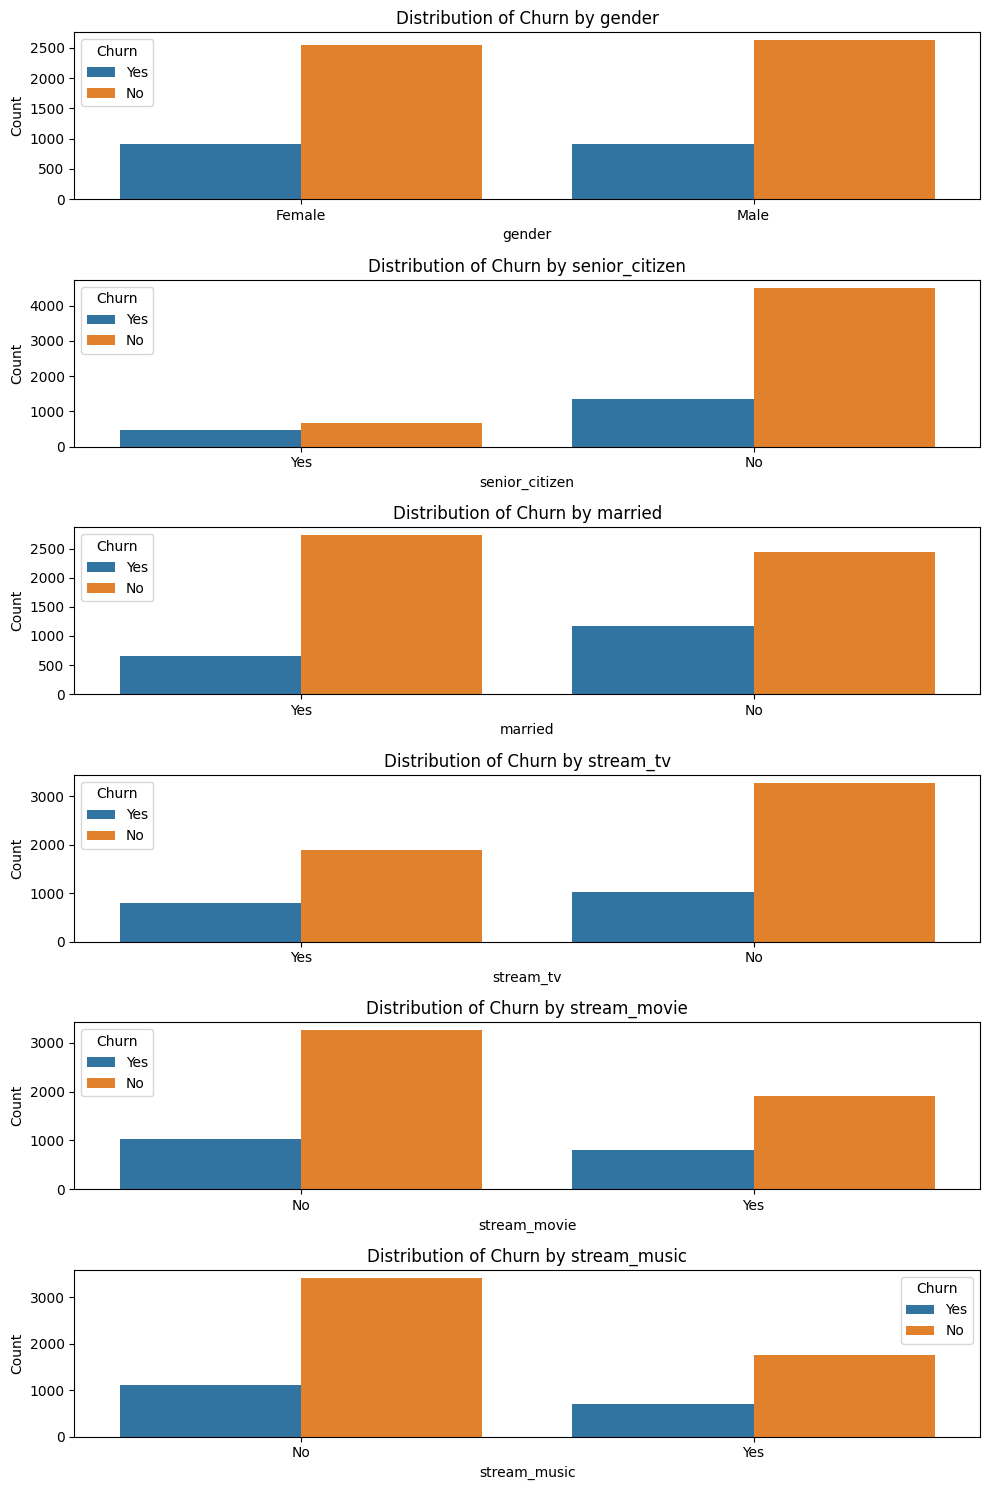

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of categorical features to examine
features_to_examine = ['gender', 'senior_citizen', 'married', 'stream_tv', 'stream_movie', 'stream_music']

# Set up the figure and axes
fig, axs = plt.subplots(nrows=len(features_to_examine), figsize=(10, 15))

for i, feature in enumerate(features_to_examine):
    sns.countplot(data=df, x=feature, hue='churn_label', ax=axs[i])
    axs[i].set_title(f'Distribution of Churn by {feature}')
    axs[i].set_ylabel('Count')
    axs[i].legend(title='Churn')

# Adjust layout
plt.tight_layout()
plt.show()


Here are some observations from the visualizations:

Gender: The churn rate seems fairly balanced between males and females.
Senior Citizen: Non-senior citizens have a higher count, but senior citizens seem to have a slightly higher churn rate compared to their overall count.
Married: Customers who are not married have a relatively higher churn rate than those who are married.|
Stream TV: Customers who do not stream TV have a higher churn rate compared to those who do.
Stream Movie: Similar to streaming TV, customers who do not stream movies tend to churn more.
Stream Music: The churn pattern is relatively similar for both categories.

# 3. Feature Engineering

In [24]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Filter out columns with missing values
missing_values = missing_values[missing_values > 0]

missing_values


churn_label         52
churn_category    5174
churn_reason      5174
internet_type     1526
dtype: int64

In [25]:
# Create a copy of the df.
data = df

In [26]:
# Cleaning the data and column

# Remove rows with missing churn_label values
data = data.dropna(subset=['churn_label'])

# Drop the churn_category and churn_reason columns
data = data.drop(columns=['churn_category', 'churn_reason','account_id','customer_id','age_group','status','zip_code','area_id','population','city','has_phone_service','total_refunds',\
                        'has_internet_service','stream_tv','has_device_protection','has_multiple_lines','has_unlimited_data','stream_movie','gender','has_online_backup','senior_citizen',\
                        'has_online_security'])

In [27]:
# Get unique values for remaining features.
features = [
    "contract_type", "num_referrals", "total_monthly_fee", "num_dependents", "age",
    "total_charges_quarter", "tenure_months", "avg_gb_download_monthly", 
    "total_long_distance_fee", "avg_long_distance_fee_monthly", "internet_type",
    "payment_method", "stream_music", "paperless_billing", "married", 
    "has_premium_tech_support"
]

# Extract unique values for each feature
unique_values = {feature: data[feature].unique() for feature in features}
unique_values

{'contract_type': array(['Month-to-Month', 'Two Year', 'One Year'], dtype=object),
 'num_referrals': array([ 3,  8,  0,  9,  1, 10,  5,  4,  2,  7,  6, 11], dtype=int64),
 'total_monthly_fee': array([ 83.9 ,  84.65,  90.45, ...,  72.2 ,  39.95, 110.7 ]),
 'num_dependents': array([0, 1, 2, 3, 6, 5, 4, 7, 9, 8], dtype=int64),
 'age': array([75, 52, 43, 32, 39, 58, 79, 30, 37, 23, 48, 28, 60, 20, 19, 64, 54,
        50, 25, 72, 51, 66, 71, 49, 61, 40, 29, 62, 42, 55, 76, 57, 24, 77,
        56, 73, 59, 22, 33, 53, 38, 35, 44, 80, 45, 41, 63, 46, 21, 70, 47,
        34, 74, 27, 36, 26, 67, 68, 31, 78, 69, 65], dtype=int64),
 'total_charges_quarter': array([ 267.4 , 5377.8 , 5957.9 , ..., 4627.85, 1612.75,   18.9 ]),
 'tenure_months': array([ 3, 63, 65, 72, 56, 71, 50, 23, 55, 37, 49, 66, 67, 59, 27, 14,  1,
        29, 64, 40, 30, 70, 32, 16,  7, 61, 15,  2, 44, 12, 47, 58,  9, 46,
        35, 52, 11,  6,  8, 68, 36, 22, 20, 54, 60, 25, 62, 41, 53, 48, 13,
        10, 45, 57,  5, 28, 18, 2

In [28]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    if column != 'churn_label':  # We'll handle the target variable separately
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le

# Encode the target variable
target_encoder = LabelEncoder()
data['churn_label'] = target_encoder.fit_transform(data['churn_label'])

# Scale numerical features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'churn_label' in numerical_features:
    numerical_features.remove('churn_label') #numerical_features.remove('churn_label')  # Remove target variable from scaling

scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Show the preprocessed data
data.head()


,churn_label,age,married,num_dependents,tenure_months,num_referrals,internet_type,has_premium_tech_support,contract_type,paperless_billing,payment_method,avg_long_distance_fee_monthly,total_long_distance_fee,avg_gb_download_monthly,stream_music,total_monthly_fee,total_charges_quarter
0,1,1.702180,1,-0.488063,-1.201488,0.345262,2,1,0,1,1,-1.008082,-0.860250,-0.466493,0,0.638213,-0.889922
1,0,0.329032,1,-0.488063,1.242649,2.007606,2,1,2,1,1,-0.646920,0.076466,-0.662240,0,0.663112,1.362603
2,0,-0.208287,1,0.548718,1.324121,0.345262,0,1,2,1,1,0.356308,1.295115,-0.319682,1,0.855662,1.618295
3,0,-0.865010,0,-0.488063,1.609270,-0.652145,2,0,2,1,0,-1.340118,-0.695321,-0.221808,0,1.215864,2.192776
4,0,-0.447095,0,-0.488063,0.957500,-0.652145,1,1,2,0,0,-1.485748,-0.886358,-0.074998,0,-0.651540,0.120638


# 4. Experimentation Modelling

## Logistic Regression

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score

# Split the data into training and testing sets
X = data.drop(columns=['churn_label'])  # Drop non-informative columns
y = data['churn_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)


# Predict on the testing set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calculate the probability scores of each of the datapoints
y_score = clf.predict_proba(X_test)[:,1]

# Calculate AUC
auc = roc_auc_score(y_test, y_score)

print(f"The AUC is {auc}")
print(f"The accuracy is {accuracy}")
print(classification_rep)
print(confusion)


The AUC is 0.8910478057720689
The accuracy is 0.8406004288777699
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1037
           1       0.69      0.69      0.69       362

    accuracy                           0.84      1399
   macro avg       0.79      0.79      0.79      1399
weighted avg       0.84      0.84      0.84      1399

[[927 110]
 [113 249]]


## Catboost

In [30]:
from catboost import CatBoostClassifier

# Initialize CatBoostClassifier
model = CatBoostClassifier(verbose=0, random_seed=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calculate the probability scores of each of the datapoints
y_score = clf.predict_proba(X_test)[:,1]

# Calculate AUC
auc = roc_auc_score(y_test, y_score)

print(f"The AUC is {auc}")
print(f"The accuracy is {accuracy}")
print(classification_rep)

The AUC is 0.8910478057720689
The accuracy is 0.8484631879914224
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1037
           1       0.73      0.65      0.69       362

    accuracy                           0.85      1399
   macro avg       0.81      0.78      0.79      1399
weighted avg       0.84      0.85      0.85      1399



## Feature Imoprtance

This code block has been repeated. Any column where feature importance less than 1 is removed.

                          Feature  Importance
7                   contract_type   15.807395
4                   num_referrals   14.006157
14              total_monthly_fee    9.948470
2                  num_dependents    9.658414
0                             age    8.234801
15          total_charges_quarter    6.202019
3                   tenure_months    5.910270
12        avg_gb_download_monthly    5.386292
11        total_long_distance_fee    5.256757
10  avg_long_distance_fee_monthly    5.145018
5                   internet_type    3.607469
9                  payment_method    3.269651
13                   stream_music    2.392992
8               paperless_billing    1.816283
1                         married    1.694167
6        has_premium_tech_support    1.663845


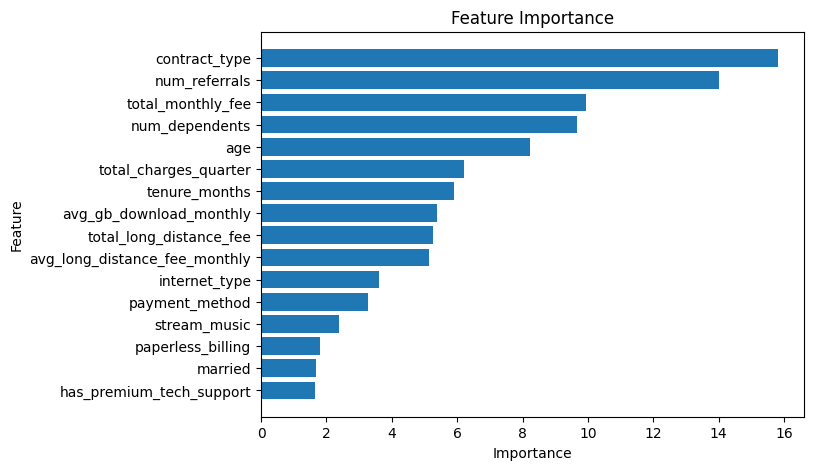

In [31]:
# 2. Extract feature importance
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# Create a DataFrame for the importances and sort by importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# 3. (Optional) Visualize the feature importance
plt.figure(figsize=(7, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# 5. Hyperparameter Tuning.

In [32]:
%%time

from sklearn.model_selection import GridSearchCV

# Define hyperparameters and their possible values
param_grid = [
    {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.2, 0.5, 0.8]},
    {'penalty': ['none'], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
]
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print(f"The best parameter is {best_params}")



Fitting 5 folds for each of 64 candidates, totalling 320 fits
The best parameter is {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
CPU times: total: 625 ms
Wall time: 4.79 s


In [33]:
%%time

from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the hyperparameters and their distributions
param_dist = {
    'learning_rate': np.logspace(-3, 0, 10),
    'depth': [4, 5, 6, 7, 8, 9, 10],
    'l2_leaf_reg': np.logspace(-3, 3, 7),
    'iterations': [100, 200, 300, 400, 500],
    'border_count': [32, 64, 128, 255]
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    CatBoostClassifier(random_seed=42, verbose=0),
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='accuracy',
    cv=5,
    n_jobs=-1,  # Use all CPU cores
    random_state=42
)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Extract the best hyperparameters
best_params = random_search.best_params_

best_params


CPU times: total: 516 ms
Wall time: 16.4 s


{'learning_rate': 0.1,
 'l2_leaf_reg': 10.0,
 'iterations': 200,
 'depth': 5,
 'border_count': 32}

In [34]:
#from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train a Logistic Regression model with the best parameters
best_clf = CatBoostClassifier(**best_params,verbose=0, random_seed=42)
best_clf.fit(X_train, y_train)

# Predict on the testing set
y_pred_best = best_clf.predict(X_test)

# Evaluate the model
accuracy_best = accuracy_score(y_test, y_pred_best)
confusion_best = confusion_matrix(y_test, y_pred_best)
classification_rep_best = classification_report(y_test, y_pred_best)

# Calculate the probability scores of each of the datapoints
y_score = clf.predict_proba(X_test)[:,1]

# Calculate AUC
auc = roc_auc_score(y_test, y_score)

print(f"The AUC is {auc}")
print(f"The accuracy is {accuracy_best}")
print(classification_rep_best)


The AUC is 0.8910478057720689
The accuracy is 0.854181558255897
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1037
           1       0.75      0.66      0.70       362

    accuracy                           0.85      1399
   macro avg       0.82      0.79      0.80      1399
weighted avg       0.85      0.85      0.85      1399



# 6. Exporting Pickle file.

In [35]:
import pickle
directory = "../model/"


pickle.dump(best_clf, open(os.path.join(directory, 'best_clf.pkl'), 'wb'))